# clover-on-clover connected proton charge radius

In [1]:
import numpy as np
import pandas as pd
import gvar as gv
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm

# read csv file into dataframe
## ensemble information
+ 0.12fm lattice spacing
+ pion mass 400 MeV
+ isoclover

## configuration information
+ 1000 to 2950 skip 10 (196 configurations)
    + configuration 1470 is missing for baryon 2pt tsrc 48, idx = 47
+ two point correlation function
    + `bar_s22_SS_tsrc_[0,48].dat.[re,im]`
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence
        + *e.g.* `bar_s22_S0src_S0_px0_py0_pz0_t0_re`
+ three point correlation function
    + `barff_s22_SS_g8_T[10,14]_tsrc_[0,48].dat.[re,im]`
    + `g8` corresponds to the `V4` current insertion
    + `T[10,14]` is snk location
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum transfer (snk at zero momentum) `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence at current insertion
        + *e.g.* `barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_t0_re`

## strategy
+ read zero momentum spatial correlator
+ perform source average
+ construct two and three point (with momentum transfer)
+ construct moment correlators

## notes
+ read PP src snk

In [2]:
# data parameters
dataset2 = 'bar_s22_SS_tsrc_SRC.dat.re'
dataset3 = 'barff_s22_SS_g8_TSNK_tsrc_SRC.dat.re'
zdata = dict()
# read two point
dataset = list()
for s in [0,48]: # automatically read both sources
    rd = dataset2.replace('SRC',str(s))
    df = pd.read_csv('./data/%s' %rd,delimiter=' ',header=None)
    tag = df[0][0]
    key =tag.replace('t0_','')
    # read zero momentum spatial correlator
    corr = np.array([np.array(df.loc[df[0] == tag.replace('t0','t%s' %t)].as_matrix())[:,1:-1] for t in range(96)])
    corr = np.swapaxes(corr,0,1) # swap axis to get [cfg,t,z]
    # delete missing config 1470 from other datasets
    if len(corr) == 196:
        corr = np.delete(corr,47,axis=0)
    dataset.append(corr)
    # average sources
zdata[key] = (dataset[0]+dataset[1])/2
print('2pt:',key,np.shape(zdata[key]))
# read three point
for snk in [10,14]:
    dataset=list()
    for s in [0,48]:
        rd = dataset3.replace('SRC',str(s)).replace('SNK',str(snk))
        df = pd.read_csv('./data/%s' %rd,delimiter=' ',header=None)
        tag = df[0][0]
        key = tag.replace('t0_','')
        # read zero momentum spatial correlator
        corr = np.array([np.array(df.loc[df[0] == tag.replace('t0','t%s' %t)].as_matrix())[:,1:-1] for t in range(96)])
        corr = np.swapaxes(corr,0,1) # swap axis to get [cfg,t,z]
        # delete missing config 1470 from other datasets
        if len(corr) == 196:
            corr = np.delete(corr,47,axis=0)
        dataset.append(corr)
    # average sources
    zdata[key] = (dataset[0]+dataset[1])/2
    print('3pt:',key,np.shape(zdata[key]))

2pt: bar_s22_S0src_S0_px0_py0_pz0_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re (195, 96, 32)


# plot correlator in z-direction

<IPython.core.display.Javascript object>


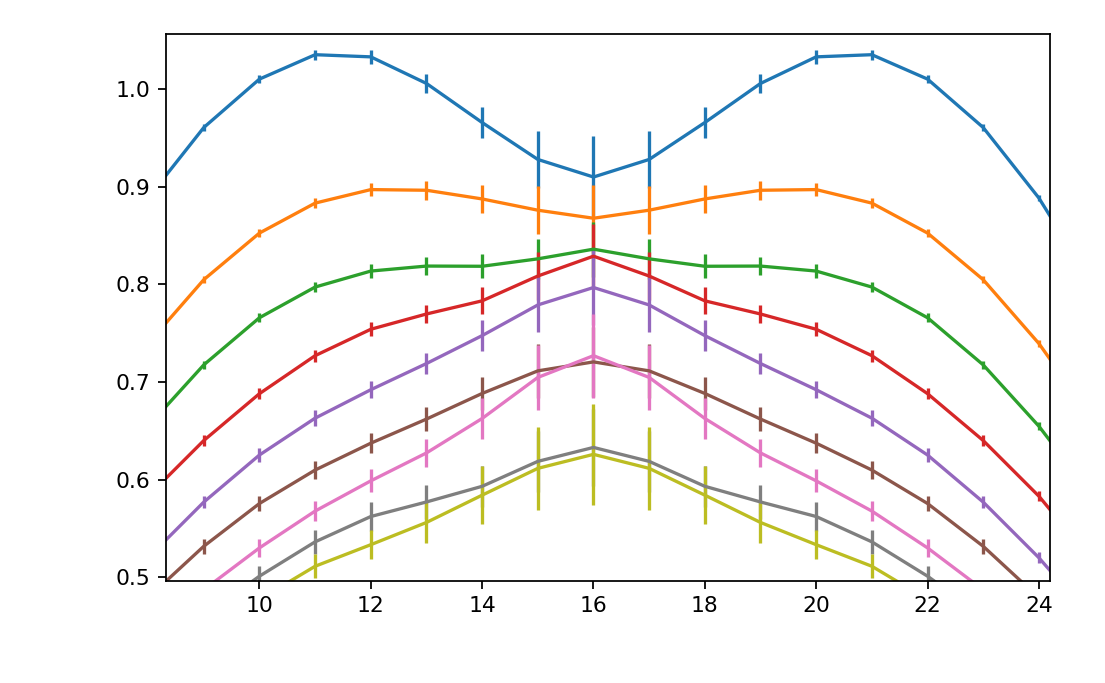

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


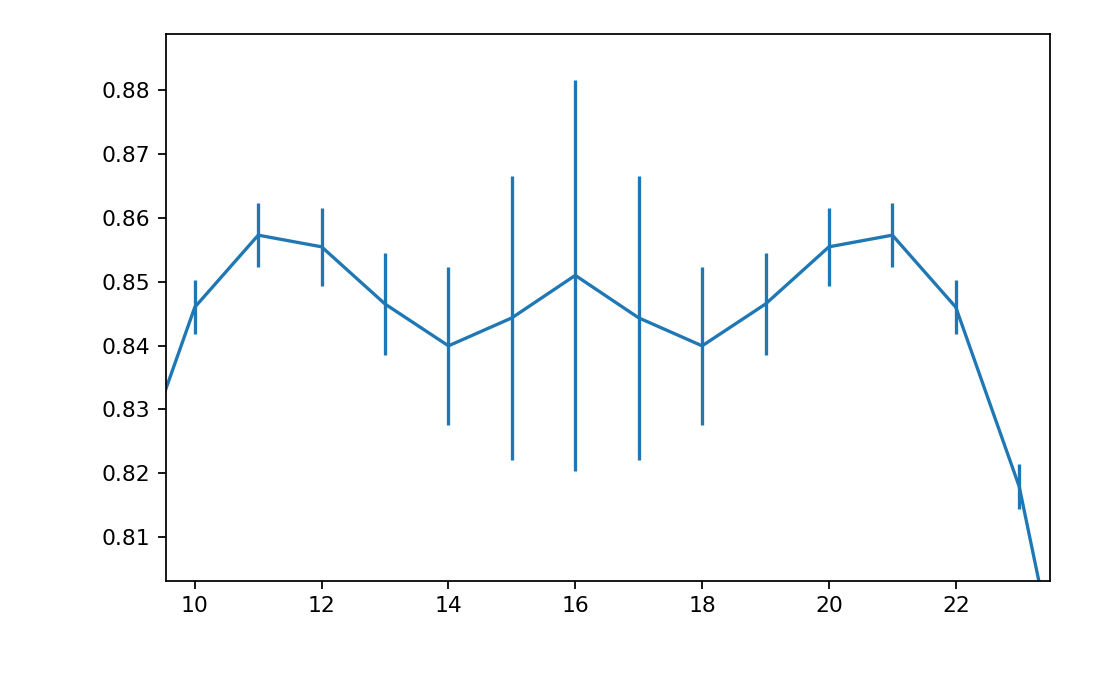

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


In [31]:
# two point
trange = [0,8]
fig = plt.figure('2pt z^2-meff',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
z = np.arange(1,32)
rz2 = np.roll((np.arange(0,32)-15)**2,17)
for t in range(trange[0],trange[1]+1):
    pltdata = gv.dataset.avg_data(zdata['bar_s22_S0src_S0_px0_py0_pz0_re'][:,t,:])
    pltdata = (pltdata + np.roll(pltdata[::-1],1))/2 # fold data
    #meff =  pltdata[z] #(0.5*rz2*pltdata)[z] #np.log(gvdata/np.roll(gvdata,-1))[z]
    meff = np.arccosh((np.roll(pltdata,1)+np.roll(pltdata,-1))/(2*pltdata))[z]
    ax.errorbar(z,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
#ax.set_yscale("log")
plt.draw()
fig = plt.figure('2pt z-meff t sum',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
pltdata = gv.dataset.avg_data(np.sum(zdata['bar_s22_S0src_S0_px0_py0_pz0_re'],axis=1))
pltdata = (pltdata + np.roll(pltdata[::-1],1))/2 # fold data
#meff = (0.5*rz2*pltdata)[z] #np.log(gvdata/np.roll(gvdata,-1))[z]
meff = np.arccosh((np.roll(pltdata,1)+np.roll(pltdata,-1))/(2*pltdata))[z]
ax.errorbar(z,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
#ax.set_yscale("log")
plt.draw()
# three point
#trange = [0,5]
#fig = plt.figure('gV',figsize=(7,4.326237))
#ax = plt.axes([0.15,0.15,0.8,0.8])
#z = np.arange(1,32)
#rz2 = np.roll((np.arange(0,32)-15)**2,17)
#for t in range(trange[0],trange[1]+1):
#    pltdata = gv.dataset.avg_data(zdata['barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re'][:,t,:])
    #pltdata = (pltdata + np.roll(pltdata[::-1],1))/2 # fold data
#    meff =  pltdata[z] #(0.5*rz2*pltdata)[z] #np.log(gvdata/np.roll(gvdata,-1))[z]
#    ax.errorbar(z,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
#ax.set_yscale("log")
#plt.draw()
# three point
#trange = [0,5]
#fig = plt.figure('gV2',figsize=(7,4.326237))
#ax = plt.axes([0.15,0.15,0.8,0.8])
#z = np.arange(1,32)
#rz2 = np.roll((np.arange(0,32)-15)**2,17)
#pltdata = gv.dataset.avg_data(np.sum(zdata['barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re'],axis=2))
#pltdata = (pltdata + np.roll(pltdata[::-1],1))/2 # fold data
#meff =  pltdata[z] #(0.5*rz2*pltdata)[z] #np.log(gvdata/np.roll(gvdata,-1))[z]
#ax.errorbar(z,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
#ax.set_yscale("log")
#plt.draw()

# construct two and three point correlators
+ Lattice 2016 proceedings @ https://arxiv.org/pdf/1610.02354.pdf
+ project to definite momentum

In [4]:
mom = [0,1,2] # momentum transfer
data = dict()
# two point correlation function
for n in mom:
    k = 2.*np.pi*n/32
    pos = zdata['bar_s22_S0src_S0_px0_py0_pz0_re']*np.cos(k*np.arange(32))
    neg = zdata['bar_s22_S0src_S0_px0_py0_pz0_re']*np.cos(-k*np.arange(32))
    data['nucleon_q%s' %n] = np.sum((pos+neg)/2,axis=2)
# gV correlation function
for n in mom:
    k = 2.*np.pi*n/32
    pos = zdata['barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_re']*np.cos(k*np.arange(32))
    neg = zdata['barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_re']*np.cos(-k*np.arange(32))
    data['gV_T10_q%s' %n] = np.sum((pos+neg)/2,axis=2)
    pos = zdata['barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re']*np.cos(k*np.arange(32))
    neg = zdata['barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re']*np.cos(-k*np.arange(32))
    data['gV_T14_q%s' %n] = np.sum((pos+neg)/2,axis=2)
data.keys()

dict_keys(['nucleon_q0', 'nucleon_q1', 'nucleon_q2', 'gV_T10_q0', 'gV_T14_q0', 'gV_T10_q1', 'gV_T14_q1', 'gV_T10_q2', 'gV_T14_q2'])

# construct moments of correlation functions

# construct correlated dataset

In [5]:
gvdata = gv.dataset.avg_data(data)
for k in gvdata.keys():
    print(k,np.shape(gvdata[k]))

nucleon_q0 (96,)
nucleon_q1 (96,)
nucleon_q2 (96,)
gV_T10_q0 (96,)
gV_T14_q0 (96,)
gV_T10_q1 (96,)
gV_T14_q1 (96,)
gV_T10_q2 (96,)
gV_T14_q2 (96,)


# plot correlation function

<IPython.core.display.Javascript object>


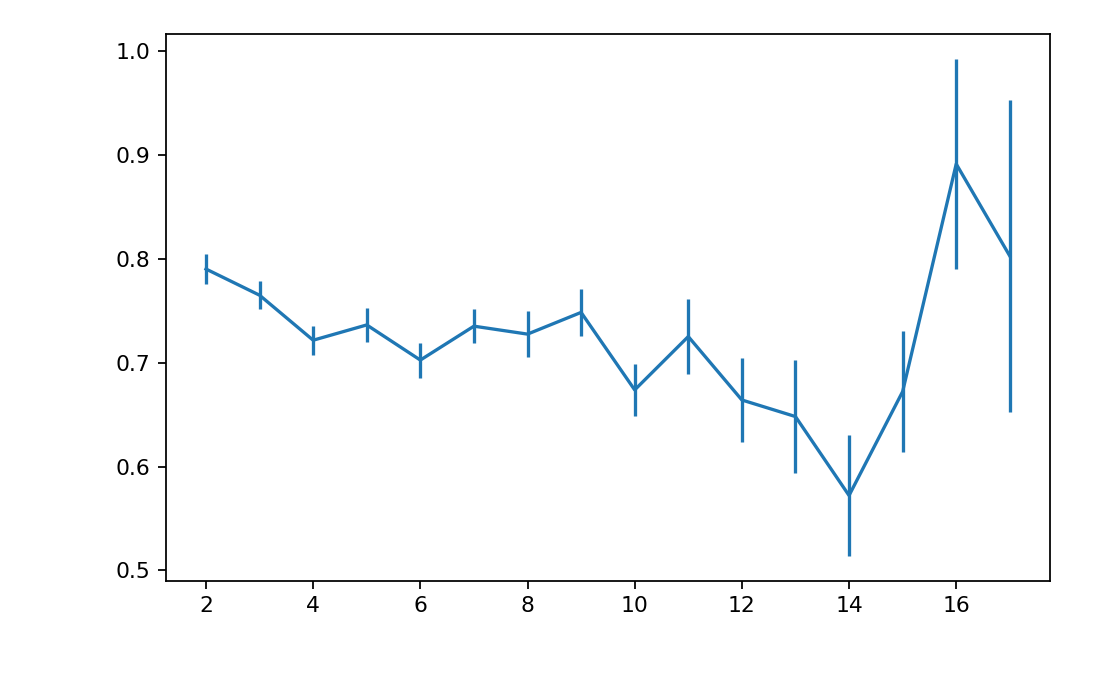

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


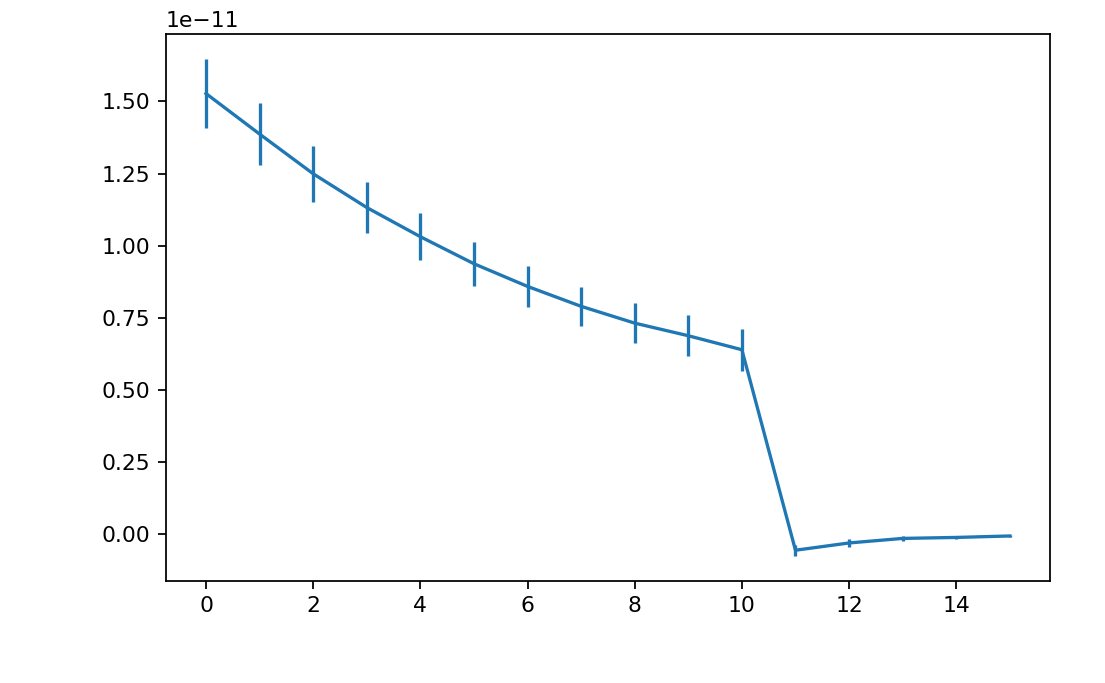

In [6]:
fig = plt.figure('meff',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
x = np.arange(2,18)
meff = np.log(gvdata['nucleon_q0']/np.roll(gvdata['nucleon_q0'],-1))[x]
ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
plt.draw()
fig = plt.figure('correlator',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
x = np.arange(0,16)
meff = gvdata['gV_T10_q2'][x]
ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
plt.draw()

In [7]:
197/0.118*0.72

1202.033898305085

In [27]:
197/0.12*0.84

1379.0